In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # здесь вы можете продолжить, например,cuda:1 cuda:2... и т. д. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [3]:
REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                    except Exception as e:
                        pass
                        #print(label, f, str(e))
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

600


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).
    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size].to(device)
train_y = y[:-val_size].to(device)
test_X = X[-val_size:].to(device)
test_y = y[-val_size:].to(device)

print(len(train_X), len(test_X))

60
540 60


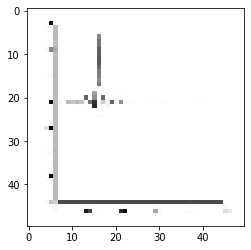

In [7]:
import matplotlib.pyplot as plt
plt.imshow(X[300], cmap="gray")

In [6]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss 

In [7]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss
val_acc, val_loss = test(size=100)
print(val_acc, val_loss) 

0.4666666666666667 tensor(0.2500, grad_fn=<MseLossBackward>)


In [8]:
MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 30
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net) 

100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


In [9]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss
val_acc, val_loss = test(size=100)
print(val_acc, val_loss) 

1.0 tensor(0.0002, grad_fn=<MseLossBackward>)


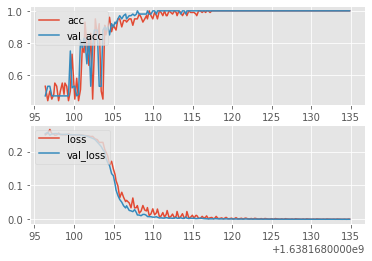

In [10]:
style.use("ggplot")
model_name = MODEL_NAME #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.
def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()
create_acc_loss_graph(model_name) 